## Introduction

In the fast-paced realm of NFL football, where every yard gained or lost can be the difference between victory and defeat, evaluating defensive performance becomes paramount. The primary goal of this project is to delve into the intricacies of a team's defensive capabilities, measured through the lens of **"Yards Saved Above Expected"** and the consequential yards allowed due to missed tackles. By analyzing these metrics, these insights aim to provide coaches and teams with a comprehensive understanding of their defensive strengths and weaknesses, ultimately offering valuable insights into the plays that shape the outcome of a game.

Once the ball is snapped and in play, the defense's mission is clear: minimize the yardage gained by the opposing team. A single well-executed tackle or, conversely, a missed tackle, can be a game-changer. The significance of these moments cannot be overstated; a successful tackle can prevent a potential scoring play, while a failed one might allow the offense to seize a crucial advantage. In this context, effective tackle performance emerges as a pivotal indicator of a team's overall defensive prowess.To achieve these insights, we employed a sophisticated approach, utilizing a histogram-based gradient boosting regression tree. This machine learning model is trained on data from weeks 1 to 8, incorporating essential factors from each play. Subsequently, the model is applied to week 9 data, enabling a comprehensive evaluation of team performances during this pivotal period.

In the following sections, I will delve into the methodology, present key findings, and illuminate plays of significant impact. This analysis strives to empower teams and coaches with actionable information, fostering a deeper understanding of their defensive strategies and setting the stage for continuous improvement.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

## Data Preparation

In the pursuit of assessing defensive performance in the NFL, it was necessary to clean up the data and be meticulous about what exactly should be evaluated. The key features in the data that were considered are as follows:
* **Tracking Data**: gameId, playId, nflId, frameId, playDirection, x, y, event
* **Game Data**: gameId, week, homeTeamAbbr, visitorTeamAbbr
* **Play Data**: gameId, playId, ballCarrierId, yardsToGo, defensiveTeam, passResult, playResult, playNullifiedByPenalty, offenseFormation, defendersInTheBox
* **Player Data**: nflId, displayName
* **Tackles Data**: gameId, playId, nflId, tackle, assist, forcedFumble, pff_missedTackle

As mentioned in the introduction, the data was split into two subsets: data from Weeks 1-8 and data from Week 9. Data from Weeks 1-8 was used to train the ML model used. The model was then applied to Week 9 to generate insights.

In [2]:
tracking_data = pd.DataFrame()

for week in range(1, 10):
    file_path = f'../input/nfl-big-data-bowl-2024/tracking_week_{week}.csv'  
    week_data = pd.read_csv(file_path)
    tracking_data = pd.concat([tracking_data, week_data], ignore_index=True)
    raw_tracking_data = pd.concat([tracking_data, week_data], ignore_index=True)
    
tracking_data = tracking_data.drop(columns=["displayName", "frameId", "time", "jerseyNumber", "playDirection", "s", "a", "dis","o","dir" ])
tracking_data = tracking_data[(tracking_data['club'] != 'football')]
tracking_data = tracking_data[(tracking_data['event'] == 'pass_outcome_caught') | (tracking_data['event'] == 'handoff') | (tracking_data['event'] == 'run') | (tracking_data['event'] == 'lateral') | (tracking_data['event'] == 'pass_shovel') | (tracking_data['event'] == 'snap_direct')]

In [3]:
plays_df = pd.read_csv('../input/nfl-big-data-bowl-2024/plays.csv')
games_df = pd.read_csv('../input/nfl-big-data-bowl-2024/games.csv')
tackles_df = pd.read_csv('../input/nfl-big-data-bowl-2024/tackles.csv')
players_df = pd.read_csv('../input/nfl-big-data-bowl-2024/players.csv')
raw_plays_df = pd.read_csv('../input/nfl-big-data-bowl-2024/plays.csv')

plays_df = plays_df.drop(columns=["quarter", "down", "gameClock", "yardlineSide", "yardlineNumber", "ballCarrierDisplayName", "penaltyYards", "preSnapHomeScore", "passProbability", "preSnapVisitorScore","absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "preSnapVisitorTeamWinProbability", "homeTeamWinProbabilityAdded", "visitorTeamWinProbilityAdded", "expectedPoints", "expectedPointsAdded", "foulName1", "foulName2", "foulNFLId1", "foulNFLId2"])
plays_df = plays_df[(plays_df['playNullifiedByPenalty'] == 'N')]
plays_df["passResult"] = plays_df["passResult"].fillna("RUN")

games_df = games_df.drop(columns=["season", "gameDate", "gameTimeEastern", "homeFinalScore", "visitorFinalScore"])

In [4]:
week_1_to_8_gameIds = games_df[games_df['week'].isin(range(1, 9))]['gameId']
week_9_gameIds = games_df[games_df['week'] == 9]['gameId']

In [5]:
game_tackles_df = pd.merge(plays_df, tackles_df, on=['gameId', 'playId'])
game_tackles_df = game_tackles_df[((game_tackles_df['tackle'] == 1) | (game_tackles_df['assist'] == 1))]

### Custom Data Insight: DistanceFromClosestDefender
One important factor when it comes to tackling is how close a defender is to the ball carrier. If the ball is thrown down the field and there is no defender within 5 yards of the receiver, the receiver will typically gain more yards than they would if the defender was running alongside the receiver, just half a yard away. Since this data was not provided alongside the tracking data, it was important to quantify the proximity of the ball carrier to the nearest defender at the moment the ball is in play and no longer with the quarterback (unless in the case of a QB scramble).

The distance metric serves as a crucial input for our machine learning model, capturing the effectiveness of defensive positioning in relation to typical yards gained during a play. The provided **getDistance** function takes the x and y coordinates of two player positions on the field - one representing the ball carrier and the other a defender, and calculates the Euclidean distance between them using the Pythagorean theorem.

The **getClosestDefender** function is applied to each tackle row in the data. It identifies the home and visitor team in order to not take in account offensive players proximities to the ball carrier. The function then selects the position data for all defensive players on that same play and calculates the distance to the ball carrier using the getDistance function outlined above. The minimum distance among all defenders is determined and returned as the result. This value is then used in the model to help evaluate the effectiveness of the tackles that are occurring. 

In [6]:
def getDistance(player_x, player_y, ball_carrier_x, ball_carrier_y):
    return ((player_x - ball_carrier_x) ** 2 + (player_y - ball_carrier_y) ** 2) ** 0.5

def getClosestDefender(row):
    selected_game = games_df[games_df['gameId'] == row['gameId']].values[0]
    game_tracking_df = tracking_data[tracking_data['gameId'] == row['gameId']]
    
    homeTeam = selected_game[2]
    visitorTeam = selected_game[3]
    
    playId = row['playId']
    ballCarrierId = row['ballCarrierId']
    ball_in_hand_play_df = game_tracking_df[(game_tracking_df['nflId'] == ballCarrierId) & (game_tracking_df['playId'] == playId)]
    if len(ball_in_hand_play_df['club'].values) > 0:
        ballCarrierClub = ball_in_hand_play_df['club'].values[0]
        
        if ballCarrierClub == homeTeam:
            opponent_club = visitorTeam
        else:
            opponent_club = homeTeam

        other_players_position_df = game_tracking_df[(game_tracking_df['nflId'] != ballCarrierId) & (game_tracking_df['playId'] == playId) & (game_tracking_df['club'] == opponent_club)]
    
        if not ball_in_hand_play_df.empty:
            ball_carrier_x = ball_in_hand_play_df['x'].values[0]
            ball_carrier_y = ball_in_hand_play_df['y'].values[0]

            other_players_position_df['distance_to_ball_carrier'] = getDistance(other_players_position_df['x'], other_players_position_df['y'], ball_carrier_x, ball_carrier_y)
            min_distance = other_players_position_df['distance_to_ball_carrier'].min()

            return min_distance
    else:
        return 'NaN'
    
    
game_tackles_df['distanceFromClosestDefender'] = game_tackles_df.apply(getClosestDefender, axis=1)

In [7]:
game_tackles_df = game_tackles_df.dropna(subset=['distanceFromClosestDefender'])
game_tackles_df = game_tackles_df.drop(columns=['possessionTeam', 'passLength', 'playNullifiedByPenalty'])

## Using ML To Calculate 'yardsSavedAboveExpected'

### Variables Used in the Model
* **offenseFormation**: Formation used by the possession team, transformed into a numerical representation using a LabelEncoder
* **passResult**: Dropback outcome of the play, all NA values were treated as run plays, transformed into a numerical representation using a LabelEncoder
* **defendersInTheBox**: Number of defenders in close proximinity to line-of-scrimmage
* **yardsToGo**: Distance needed for a first down
* **distanceFromClosestDefender**: Metric calculated to represent the proximity of the ball carrier to the nearest defender at the moment the ball is in play
* **prePenaltyPlayResult**: Net yards gained by the offense, before penalty yardage

### Histogram-Based Gradient Boosting Regressor
The choice of using a Histogram-Based Gradient Boosting Regressor for this specific use case was due to the following factors:
* **Robustness to Outliers**
    * Gradient Boosting models, in general, are known for their robustness to outliers. The ensemble nature of boosting helps in reducing the impact of individual data points that might have extreme values, making the model more resilient to noisy data.
* **Non-Linear Relationships**
    * A histogram-based approach is well-suited for capturing non-linear relationships within the data. In the context of NFL tackle performance, where the impact of various factors on play outcomes may not follow a linear pattern, a non-linear model can better capiture the complexities of the relationships.
* **Predicting Continuous Outputs**
    * Since the task involves predicting yards gained on tackling plays, which is a continuous variable, a regression model is appropriate. Gradient Boosting Regressors excelt at predicting continuous outputs.
* **Consistent Model Performance**
    * Gradient Boosting models, including the histogram-based variant, often exhibit stable and reliable performance across different types of datasets. This consistency is valuable for generating reliable insights in a sports analytics context.


In [8]:
le = LabelEncoder()

game_tackles_df['offenseFormation_idx'] = le.fit_transform(game_tackles_df['offenseFormation'])
game_tackles_df['playType_idx'] = le.fit_transform(game_tackles_df['passResult'])

mean_value = game_tackles_df['defendersInTheBox'].mean()
game_tackles_df.loc[game_tackles_df['defendersInTheBox'].isna(), 'defendersInTheBox'] = mean_value

weeks_1_to_8_tackles_df = game_tackles_df[game_tackles_df['gameId'].isin(week_1_to_8_gameIds)]
week_9_tackles_df = game_tackles_df[game_tackles_df['gameId'].isin(week_9_gameIds)]

X_train = weeks_1_to_8_tackles_df[['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']]
y_train = weeks_1_to_8_tackles_df['prePenaltyPlayResult']

X_test = week_9_tackles_df[['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']]
y_test = week_9_tackles_df['prePenaltyPlayResult']

X_train.loc[X_train['defendersInTheBox'].isna(), 'defendersInTheBox'] = X_train['defendersInTheBox'].mean()
X_test.loc[X_test['defendersInTheBox'].isna(), 'defendersInTheBox'] = X_test['defendersInTheBox'].mean()

In [9]:
regr = HistGradientBoostingRegressor()

regr.fit(X_train, y_train)

def getExpectedYards(row, regr):
    columns = ['yardsToGo', 'distanceFromClosestDefender', 'defendersInTheBox', 'offenseFormation_idx', 'playType_idx']
    data = row[columns].values.reshape(1, -1)
    df = pd.DataFrame(data, columns=columns)
    
    return round(regr.predict(df)[0], 2)

week_9_tackles_df.loc[:, 'expectedYards'] = week_9_tackles_df.apply(getExpectedYards, axis=1, regr=regr)
week_9_tackles_df.loc[:, 'yardsSavedAboveExpected'] = week_9_tackles_df['expectedYards'] - week_9_tackles_df['playResult']
week_9_tackles_df.loc[:, 'yardsSavedAboveExpected'] = week_9_tackles_df['yardsSavedAboveExpected'].apply(lambda x: max(0, x))

/tmp/ipykernel_20/629564098.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_9_tackles_df.loc[:, 'expectedYards'] = week_9_tackles_df.apply(getExpectedYards, axis=1, regr=regr)
/tmp/ipykernel_20/629564098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_9_tackles_df.loc[:, 'yardsSavedAboveExpected'] = week_9_tackles_df['expectedYards'] - week_9_tackles_df['playResult']


### Permutation Importances

As seen by the permutation importance of the model, the **playType** variable has the most impact on predicting the expected yards gained. It makes sense that this is the case, as pass plays typically allow a team to gain more yards than run plays do. The second greatest impact is from the **distanceFromClosestDefender**, which suggests that the proximity of a defender to a ball carrier or receiver plays a crucial role in determining the expected yards gained.

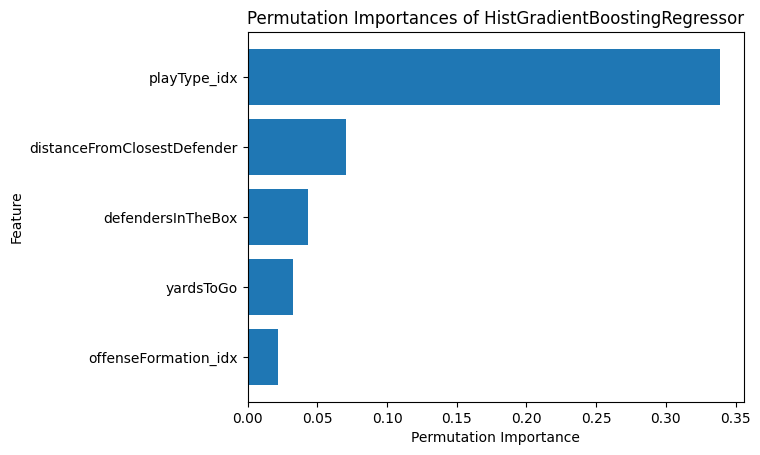

In [10]:
result = permutation_importance(regr, X_train, y_train, n_repeats=10, random_state=42)

feature_importances = result.importances_mean
feature_names = X_train.columns

sorted_idx = np.argsort(feature_importances)

plt.barh(range(len(feature_importances)), feature_importances[sorted_idx])
plt.yticks(range(len(feature_importances)), feature_names[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances of HistGradientBoostingRegressor')
plt.show()

## Determining 'yardsAllowedByMissedTackle'

The function **getYardsAllowed** identifies plays with missed tackles during week 9, extracts relevant tracking data, and calculates the yards allowed due to each missed tackle. This function makes the assumption that the point that when the defender is at the position where they are closest to the football, they are also at the position that the missed tackle takes place.

In [11]:
missed_tackles_df = week_9_tackles_df[week_9_tackles_df['pff_missedTackle'] == 1]
missed_tackles_plays = missed_tackles_df[['gameId', 'playId', 'nflId']].drop_duplicates()
missed_tackle_players = missed_tackles_plays['nflId'].drop_duplicates()

week_9_tracking_df = raw_tracking_data[raw_tracking_data['gameId'].isin(week_9_gameIds)]
week_9_tracking_missed_df = week_9_tracking_df[(week_9_tracking_df['nflId'].isin(missed_tackle_players)) | (week_9_tracking_df['club'] == 'football')]

missed_tracking_df = pd.merge(missed_tackles_plays, week_9_tracking_missed_df, on=['gameId', 'playId'], how='left')

def getYardsAllowed(row):
    selected_game_df = games_df[games_df['gameId'] == row['gameId']]
    selected_game = games_df[games_df['gameId'] == row['gameId']]['gameId'].values[0]
    playId = row['playId']
    playerId = row['nflId']
    homeTeam = selected_game_df['homeTeamAbbr'].values[0]
    awayTeam = selected_game_df['visitorTeamAbbr'].values[0]
    missed_tackle_player_tracking_df = missed_tracking_df[(missed_tracking_df['gameId'] == selected_game) & (missed_tracking_df['playId'] == playId) & (missed_tracking_df['nflId_y'] == playerId)]
    missed_tackle_football_tracking_df = missed_tracking_df[(missed_tracking_df['gameId'] == selected_game) & (missed_tracking_df['playId'] == playId) & (missed_tracking_df['displayName'] == 'football')]
    
    min_distance_frameId = None
    min_distance = np.inf

    for index, row in missed_tackle_player_tracking_df.iterrows():
        distances = np.sqrt((missed_tackle_football_tracking_df['x'] - row['x'])**2 + (missed_tackle_football_tracking_df['y'] - row['y'])**2)
        closest_frameId = missed_tackle_football_tracking_df.loc[distances.idxmin(), 'frameId']
        if distances.min() < min_distance:
            min_distance = distances.min()
            min_distance_frameId = closest_frameId
    
    missed_tackle_x_location = missed_tackle_football_tracking_df[missed_tackle_football_tracking_df['frameId'] == min_distance_frameId]['x'].values[0]
    playDirection = missed_tackle_football_tracking_df[missed_tackle_football_tracking_df['frameId'] == min_distance_frameId]['playDirection'].values[0]
    end_of_play_location = missed_tackle_football_tracking_df['x'].iloc[-6]
    
    if playDirection == 'left':
        return round(missed_tackle_x_location - end_of_play_location, 2)
    else:
        return round(end_of_play_location - missed_tackle_x_location, 2)
    
missed_tackles_df['yardsAllowedByMissedTackle'] = missed_tackles_df.apply(getYardsAllowed, axis=1)


/tmp/ipykernel_20/2546877287.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missed_tackles_df['yardsAllowedByMissedTackle'] = missed_tackles_df.apply(getYardsAllowed, axis=1)


In [12]:
columns_to_include = ['gameId', 'playId', 'nflId', 'yardsAllowedByMissedTackle']
missed_tackles_df = missed_tackles_df[columns_to_include]

In [13]:
processed_tackles_df = week_9_tackles_df.drop(columns=["ballCarrierId", "yardsToGo", "playResult", "offenseFormation", "defendersInTheBox", "distanceFromClosestDefender", "offenseFormation_idx", "playType_idx", "expectedYards"])
processed_tackles_df = pd.merge(processed_tackles_df, missed_tackles_df, on=['nflId', 'gameId', 'playId'], how='left')
processed_tackles_df.fillna(0, inplace=True)

In [14]:
most_yards_saved = processed_tackles_df.groupby('gameId')['yardsSavedAboveExpected'].idxmax()
most_yards_given_up = processed_tackles_df.groupby('gameId')['yardsAllowedByMissedTackle'].idxmax()

most_yards_saved_df = processed_tackles_df.loc[most_yards_saved, ['gameId', 'playId', 'yardsSavedAboveExpected']]
most_yards_given_up_df = processed_tackles_df.loc[most_yards_given_up, ['gameId', 'playId', 'yardsAllowedByMissedTackle']]

In [15]:
tackle_df = processed_tackles_df[(processed_tackles_df['tackle'] == 1) & (processed_tackles_df['pff_missedTackle'] != 1)]
sum_tackle = tackle_df.groupby('nflId')['yardsSavedAboveExpected'].sum()

assist_df = processed_tackles_df[(processed_tackles_df['assist'] == 1)]
sum_assist = assist_df.groupby('nflId')['yardsSavedAboveExpected'].sum() * 0.5

missed_tackle_df = processed_tackles_df[processed_tackles_df['pff_missedTackle'] == 1]
sum_missed_tackle = missed_tackle_df.groupby('nflId')['yardsAllowedByMissedTackle'].sum()

sum_tackle_reset = sum_tackle.reset_index()
sum_assist_reset = sum_assist.reset_index()
sum_missed_reset = sum_missed_tackle.reset_index()

merged_left = pd.merge(sum_tackle_reset, sum_assist_reset, on='nflId', how='left', suffixes=('_tackle', '_assist'))
merged_right = pd.merge(sum_tackle_reset, sum_assist_reset, on='nflId', how='right', suffixes=('_tackle', '_assist'))

final_sum = pd.concat([merged_left, merged_right], ignore_index=True)
final_sum = pd.merge(final_sum, sum_missed_reset, on='nflId', how='left')
final_sum = final_sum.fillna(0)

final_sum.loc[:, 'yardsSavedAboveExpected_total'] = final_sum['yardsSavedAboveExpected_tackle'] + final_sum['yardsSavedAboveExpected_assist']

In [16]:
sum_columns = ['tackle', 'assist', 'forcedFumble', 'pff_missedTackle']

total_sum = processed_tackles_df.groupby('nflId')[sum_columns].sum().reset_index()
total_sum.columns = ['nflId'] + ['total' + col.title() for col in sum_columns]
total_sum.fillna(0, inplace=True)

total_sum = pd.merge(total_sum, final_sum, on='nflId', how='left')
total_sum = pd.merge(total_sum, players_df[['nflId', 'displayName']], on='nflId', how='left')

In [17]:
unique_team_player_list_df = week_9_tackles_df.groupby('defensiveTeam')['nflId'].agg(list).reset_index()

team_list = []

for index, row in unique_team_player_list_df.iterrows():
    filtered_rows = total_sum[total_sum['nflId'].isin(row['nflId'])]
    filtered_rows = filtered_rows.drop_duplicates()
    
    sum_tackles = filtered_rows['totalTackle'].sum()
    sum_assists = filtered_rows['totalAssist'].sum()
    sum_forced_fumbles = filtered_rows['totalForcedfumble'].sum()
    sum_missed_tackle = filtered_rows['totalPff_Missedtackle'].sum()
    sum_yards_saved = filtered_rows['yardsSavedAboveExpected_tackle'].sum()
    sum_yards_allowed = filtered_rows['yardsAllowedByMissedTackle'].sum()
    
    team_list.append({
        'defensiveTeam': row['defensiveTeam'],
        'teamTotalTackles': sum_tackles,
        'teamTotalAssists': sum_assists,
        'teamTotalForcedFumbles': sum_forced_fumbles,
        'teamTotalMissedTackles': sum_missed_tackle,
        'teamTotalYardsSavedFromTackle': sum_yards_saved,
        'teamTotalYardsAllowed': sum_yards_allowed,
        'averageYardsSavedPerTackle': round(sum_yards_saved / sum_tackles, 2)
    })
    
teams_data_df = pd.DataFrame(team_list)
teams_data_df =teams_data_df.sort_values(by='teamTotalYardsSavedFromTackle', ascending=False)
display(teams_data_df)

,defensiveTeam,teamTotalTackles,teamTotalAssists,teamTotalForcedFumbles,teamTotalMissedTackles,teamTotalYardsSavedFromTackle,teamTotalYardsAllowed,averageYardsSavedPerTackle
10,IND,40,9,2,1,137.22,2.84,3.43
1,ATL,35,36,1,0,131.35,0.00,3.75
25,WAS,37,21,0,0,128.97,0.00,3.49
13,LA,39,28,0,1,121.02,0.04,3.10
22,SEA,34,9,1,0,118.95,0.00,3.50
0,ARI,45,23,0,1,110.63,0.80,2.46
16,MIA,43,23,0,1,107.86,2.98,2.51
14,LAC,37,22,1,1,107.85,4.19,2.91
24,TEN,47,30,0,2,105.60,2.94,2.25
4,CAR,44,29,0,0,96.44,0.00,2.19


In [18]:
columns = ['defensiveTeam','teamTotalTackles','averageYardsSavedPerTackle','teamTotalYardsSavedFromTackle']
teams_data_df_saved = teams_data_df[columns]
display(teams_data_df_saved.style.background_gradient(axis=0, subset='teamTotalYardsSavedFromTackle'))

,defensiveTeam,teamTotalTackles,averageYardsSavedPerTackle,teamTotalYardsSavedFromTackle
10,IND,40,3.430000,137.220000
1,ATL,35,3.750000,131.350000
25,WAS,37,3.490000,128.970000
13,LA,39,3.100000,121.020000
22,SEA,34,3.500000,118.950000
0,ARI,45,2.460000,110.630000
16,MIA,43,2.510000,107.860000
14,LAC,37,2.910000,107.850000
24,TEN,47,2.250000,105.600000
4,CAR,44,2.190000,96.440000


In [19]:
columns = ['defensiveTeam', 'teamTotalMissedTackles', 'teamTotalYardsAllowed']
teams_data_df_allowed = teams_data_df[teams_data_df['teamTotalMissedTackles'] != 0].sort_values(by='teamTotalYardsAllowed', ascending=False)
display(teams_data_df_allowed[columns].style.background_gradient(axis=0, subset='teamTotalYardsAllowed'))

,defensiveTeam,teamTotalMissedTackles,teamTotalYardsAllowed
7,DET,1,4.400000
14,LAC,1,4.190000
16,MIA,1,2.980000
24,TEN,2,2.940000
10,IND,1,2.840000
19,NO,1,2.780000
0,ARI,1,0.800000
11,JAX,1,0.050000
13,LA,1,0.040000


In [20]:
colors = {
    'ARI':["#97233F","#000000","#FFB612"], 
    'ATL':["#A71930","#000000","#A5ACAF"], 
    'BAL':["#241773","#000000"], 
    'BUF':["#00338D","#C60C30"], 
    'CAR':["#0085CA","#101820","#BFC0BF"], 
    'CHI':["#0B162A","#C83803"], 
    'CIN':["#FB4F14","#000000"], 
    'CLE':["#311D00","#FF3C00"], 
    'DAL':["#003594","#041E42","#869397"],
    'DEN':["#FB4F14","#002244"], 
    'DET':["#0076B6","#B0B7BC","#000000"], 
    'GB' :["#203731","#FFB612"], 
    'HOU':["#03202F","#A71930"], 
    'IND':["#002C5F","#A2AAAD"], 
    'JAX':["#101820","#D7A22A","#9F792C"], 
    'KC' :["#E31837","#FFB81C"], 
    'LA' :["#003594","#FFA300","#FF8200"], 
    'LAC':["#0080C6","#FFC20E","#FFFFFF"], 
    'LV' :["#000000","#A5ACAF"],
    'MIA':["#008E97","#FC4C02","#005778"], 
    'MIN':["#4F2683","#FFC62F"], 
    'NE' :["#002244","#C60C30","#B0B7BC"], 
    'NO' :["#101820","#D3BC8D"], 
    'NYG':["#0B2265","#A71930","#A5ACAF"], 
    'NYJ':["#125740","#000000","#FFFFFF"], 
    'PHI':["#004C54","#A5ACAF","#ACC0C6"], 
    'PIT':["#FFB612","#101820"], 
    'SEA':["#002244","#69BE28","#A5ACAF"], 
    'SF' :["#AA0000","#B3995D"],
    'TB' :["#D50A0A","#FF7900","#0A0A08"], 
    'TEN':["#0C2340","#4B92DB","#C8102E"], 
    'WAS':["#5A1414","#FFB612"], 
    'football':["#CBB67C","#663831"]
}

In [21]:
def hex_to_rgb_array(hex_color):
    '''take in hex val and return rgb np array'''
    return np.array(tuple(int(hex_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))) 

def ColorDistance(hex1,hex2):
    '''d = {} distance between two colors(3)'''
    if hex1 == hex2:
        return 0
    rgb1 = hex_to_rgb_array(hex1)
    rgb2 = hex_to_rgb_array(hex2)
    rm = 0.5*(rgb1[0]+rgb2[0])
    d = abs(sum((2+rm,4,3-rm)*(rgb1-rgb2)**2))**0.5
    return d

def ColorPairs(team1,team2):
    color_array_1 = colors[team1]
    color_array_2 = colors[team2]
    # If color distance is small enough then flip color order
    if ColorDistance(color_array_1[0],color_array_2[0])<500:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[1],color_array_2[0]],'football':colors['football']}
    else:
        return {team1:[color_array_1[0],color_array_1[1]],team2:[color_array_2[0],color_array_2[1]],'football':colors['football']}

In [22]:
fig = go.Figure( layout_yaxis_range=[0,53.3], layout_xaxis_range=[0,120])

team_combos = list(set(tracking_data.club.unique())-set(["football"]))
color_orders = ColorPairs(team_combos[0],team_combos[1])

In [23]:
def animate_play(games,tracking_df,play_df,players,gameId,playId):
    selected_game_df = games[games.gameId==gameId].copy()
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    
    # get good color combos
    team_combos = list(set(selected_tracking_df.club.unique())-set(["football"]))
    color_orders = ColorPairs(team_combos[0],team_combos[1])
    
    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    ## Fixing first down marker issue from last year
    if selected_tracking_df.playDirection.values[0] == "right":
        first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    else:
        first_down_marker = line_of_scrimmage - selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add Endzone Colors 
        endzoneColors = {0:color_orders[selected_game_df.homeTeamAbbr.values[0]][0],
                         110:color_orders[selected_game_df.visitorTeamAbbr.values[0]][0]}
        for x_min in [0,110]:
            data.append(
                go.Scatter(
                    x=[x_min,x_min,x_min+10,x_min+10,x_min],
                    y=[0,53.5,53.5,0,0],
                    fill="toself",
                    fillcolor=endzoneColors[x_min],
                    mode="lines",
                    line=dict(
                        color="white",
                        width=3
                        ),
                    opacity=1,
                    showlegend= False,
                    hoverinfo ="skip"
                )
            )
        # Plot Players
        for team in selected_tracking_df.club.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.club==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Player Speed:{} yd/s".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName_x"].values[0],
                                                                                      selected_player_df["s"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker=go.scatter.Marker(
                                                                                             color=color_orders[team][0],
                                                                                             line=go.scatter.marker.Line(width=2,
                                                                                                            color=color_orders[team][1]),
                                                                                             size=10),
                                        name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )
    # Add Team Abbreviations in EndZone's
    for x_min in [0,110]:
        if x_min == 0:
            angle = 270
            teamName=selected_game_df.homeTeamAbbr.values[0]
        else:
            angle = 90
            teamName=selected_game_df.visitorTeamAbbr.values[0]
        fig.add_annotation(
            x=x_min+5,
            y=53.5/2,
            text=teamName,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=32,
                color="White"
                ),
            textangle = angle
        )
    return fig

## Most Impactful Play - Yards Saved

In [24]:
display(most_yards_saved_df.sort_values(by='yardsSavedAboveExpected', ascending=False))
animate_play(games_df,week_9_tracking_df,raw_plays_df,players_df,2022110600,2183).show()

,gameId,playId,yardsSavedAboveExpected
176,2022110600,2183,47.09
1187,2022110608,1788,18.30
988,2022110300,2284,17.77
657,2022110604,78,16.51
298,2022110602,3337,16.51
1042,2022110605,3434,15.95
1010,2022110607,461,14.76
1444,2022110610,3289,13.71
1346,2022110601,3370,12.18
1103,2022110700,3278,12.03


## Most Impactful Play - Yards Given Up

In [25]:
display(most_yards_given_up_df.sort_values(by='yardsAllowedByMissedTackle', ascending=False))
animate_play(games_df,week_9_tracking_df,raw_plays_df,players_df,2022110603,441).show()

,gameId,playId,yardsAllowedByMissedTackle
162,2022110603,441,4.40
632,2022110600,2782,4.19
71,2022110601,3266,2.98
129,2022110605,1030,2.84
547,2022110700,588,2.78
368,2022110610,2875,1.76
869,2022110608,1535,0.80
1147,2022110604,2888,0.05
404,2022110609,445,0.04
9,2022110300,3229,0.00


## Resources

Credit to Hunter Kempf for the wonderful [Plotly Animated (and interactive) NFL Plays](https://www.kaggle.com/code/huntingdata11/plotly-animated-and-interactive-nfl-plays) code provided, which allowed me to focus on data analysis and not have to worry about creating animated plays myself. I changed up a few features of the code to cater to my specific use case, but it was truly a life saver.

## Acknowledgements

Thank you to the NFL for putting this competition together (and for being the source of my love of sports). A special thanks to Andrew Patton, Ally Blake & Ishani Desai, who I had the pleasure of meeting at the 2023 Women in Sports Data symposium, making me aware of the competition in the first place. 

Also a special thanks to Eric A. Eager and Richard A. Erickson, who recently published their book Football Analytics with Python & R. I found it very helpful in the process of completing this project.

As someone who has worked traditionally in software engineering and building applications and less in data science and analytics, this was an awesome project to work on. I started in September having no idea how to approach the ideas I had in my head, and am very proud of my final solution! It has inspired me to learn more about Machine Learning and create even more insights for sports analytics in future personal projects.

Lastly, thank you to my friends and family who pushed me to finish this despite any discouragements I was feeling over lack of experience and knowledge. You gotta start somewhere!